In [ ]:
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6
!kaggle -v
!mkdir -p ~/.kaggle 
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d nikhilroxtomar/person-segmentation

 99% 457M/461M [00:05<00:00, 76.8MB/s]
100% 461M/461M [00:05<00:00, 87.6MB/s]


In [ ]:
!unzip person-segmentation

In [ ]:
!git clone https://github.com/VikramShenoy97/Human-Segmentation-Dataset


Cloning into 'Human-Segmentation-Dataset'...
remote: Enumerating objects: 596, done.
remote: Total 596 (delta 0), reused 0 (delta 0), pack-reused 596
Receiving objects: 100% (596/596), 13.60 MiB | 41.95 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [ ]:
import tensorflow as tf 
import numpy as np 
from tensorflow.keras.layers import Conv2D,BatchNormalization,Dense,MaxPool2D,Conv2DTranspose,Input,Concatenate,Activation
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau

import matplotlib.pyplot as plt
import PIL
import cv2
from glob import glob

from sklearn.model_selection import train_test_split

In [ ]:
#read the model description clearly from the paper to understand the architecture
#model
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    output = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)
    model= Model(inputs=inputs,outputs=output)
    return model

input_shape = (256, 256, 3)
model = build_unet(input_shape)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
model.compile(loss="binary_crossentropy",optimizer=tf.keras.optimizers.Adam(1e-4),
        metrics=[
            tf.keras.metrics.MeanIoU(num_classes=2),
            tf.keras.metrics.Recall(),
            tf.keras.metrics.Precision()
        ]
    )

(682, 1024, 3)


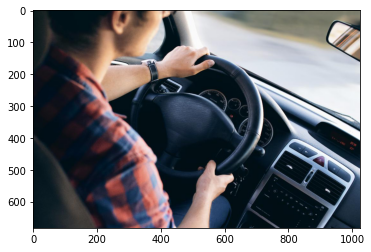

(682, 1024)


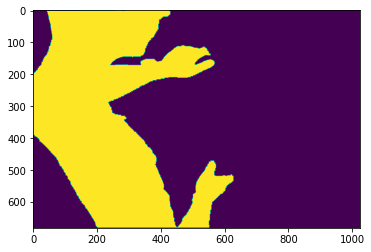

In [ ]:
# masks are between 0 and 1 and images are between 0 and 255
a=plt.imread("/content/people_segmentation/images/IMG_3496bfree.jpg")
plt.imshow(a)
print(a.shape)

plt.show()

a=plt.imread("/content/people_segmentation/masks/IMG_3496bfree.png")
plt.imshow(a)
print(a.shape)
plt.show()

In [ ]:
def read_image(path):
  x= cv2.imread(path,cv2.IMREAD_COLOR)
  x= cv2.resize(x,(256,256))
  x=x/255.0
  x=x.astype(np.float32)
  return x

def read_mask(path):
  x=cv2.imread(path,cv2.IMREAD_GRAYSCALE)
  x=cv2.resize(x,(256,256))
  x=x.astype(np.float32)
  x = np.expand_dims(x, axis=-1)
  return x

In [ ]:
def load_dataset():
  images=sorted(glob("/content/people_segmentation/images/*.jpg"))
  masks= sorted(glob("/content/people_segmentation/masks/*.png"))

  X_train,X_test= train_test_split(images,test_size=0.2,random_state=2021)
  y_train,y_test= train_test_split(masks,test_size=0.2,random_state=2021)

  return (X_train,y_train),(X_test,y_test)

In [ ]:
def preprocess(image_path, mask_path):
    def f(image_path, mask_path):
        image_path = image_path.decode()
        mask_path = mask_path.decode()

        x = read_image(image_path)
        y = read_mask(mask_path)

        return x, y

    image, mask = tf.numpy_function(f, [image_path, mask_path], [tf.float32, tf.float32])
    image.set_shape([256, 256, 3])
    mask.set_shape([256, 256, 1])

    return image, mask

def tf_dataset(images, masks, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((images, masks))
    dataset = dataset.shuffle(buffer_size=5000)
    dataset = dataset.map(preprocess)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(2)
    return dataset

In [ ]:
(train_x, train_y), (test_x, test_y) = load_dataset()
print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Test: {len(test_x)} - {len(test_y)}")

Train: 4542 - 4542
Test: 1136 - 1136


In [ ]:
batch_size=32
epochs=100
train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
test_dataset = tf_dataset(test_x, test_y, batch=batch_size)

In [ ]:
model_checkpoint=ModelCheckpoint('best_unet.h5',monitor='val_loss',save_best_only=True,mode='min')
early_stopping= EarlyStopping(monitor="val_loss",min_delta=0,patience=10,verbose=0,mode="min",restore_best_weights=True)
reduce_lr=ReduceLROnPlateau(monitor="loss",factor=0.2,patience=10,min_lr=0.001)


model.fit(train_dataset,validation_data=test_dataset,epochs=epochs, steps_per_epoch=142,validation_steps=36,callbacks=[model_checkpoint,early_stopping,reduce_lr])

Epoch 1/100
142/142 [==============================] - 276s 2s/step - loss: 0.3861 - mean_io_u: 0.3838 - recall: 0.6660 - precision: 0.7291 - val_loss: 0.6479 - val_mean_io_u: 0.4016 - val_recall: 0.5762 - val_precision: 0.6225
Epoch 2/100
142/142 [==============================] - 274s 2s/step - loss: 0.3314 - mean_io_u: 0.3912 - recall: 0.7115 - precision: 0.7616 - val_loss: 0.3620 - val_mean_io_u: 0.3934 - val_recall: 0.6088 - val_precision: 0.8023
Epoch 3/100
142/142 [==============================] - 274s 2s/step - loss: 0.2945 - mean_io_u: 0.3942 - recall: 0.7495 - precision: 0.7829 - val_loss: 0.3479 - val_mean_io_u: 0.3885 - val_recall: 0.8170 - val_precision: 0.7190
Epoch 4/100
142/142 [==============================] - 281s 2s/step - loss: 0.2715 - mean_io_u: 0.3951 - recall: 0.7679 - precision: 0.8005 - val_loss: 0.4259 - val_mean_io_u: 0.4206 - val_recall: 0.8960 - val_precision: 0.6554
Epoch 5/100
142/142 [==============================] - 276s 2s/step - loss: 0.2501 - mea

KeyboardInterrupt: ignored